In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import time
from astropy import cosmology
from astropy.cosmology import FlatLambdaCDM
repoDir= os.getcwd()
os.chdir(os.path.join( repoDir, '..' ))
repoDir= os.getcwd()
from astropy.io import ascii

In [2]:
def MC(Nrand, probs): 
    # returns probabilities after an MC run
    np.random.seed(10)
    randNs= np.random.random(Nrand)
    
    counts= np.zeros(len(probs))
    
    probs= [0]+list(probs)
    cumProbs= np.cumsum(probs)
    
    for randN in randNs:   
        for i in np.arange(1,len(probs)+1):
            if (randN> cumProbs[i-1]) and (randN<=cumProbs[i]):
                counts[i-1]+=1    
                
    return counts/Nrand

In [3]:
dataDir= repoDir+'/relative_sne/'
SNdata= ascii.read(dataDir+'relative_rates.txt')   # data from Kara P.
os.chdir(repoDir)
SNdata_zBin= SNdata['redshift']

In [4]:
def probTypes(): # assumes SNData is in the shell 
    SNdata_Ia= SNdata['SN_Ia']
    SNdata_Ibc= SNdata['SN_Ibc']
    SNdata_II= SNdata['SN_II']
    
    probs= np.zeros(shape=(len(SNdata_Ia), 3))
    for i in range(len(SNdata_Ia)):
        probs[i]= MC(1000, [SNdata_Ia[i], SNdata_Ibc[i], SNdata_II[i]])
    
    return probs

In [5]:
 def probZbin(zBins):  # assume SNdata_zBin is in the shell.
    # returns the redshift probability dist (+zBin array)
    
    def Nz(zBins):
        objCounts= zBins*10+2    #np.array([10.,5.,2.])
        fracCounts= objCounts/sum(objCounts)
        return fracCounts
    
    probs= MC(1000, Nz(zBins[1:]))
    return probs #[probs, zBins]

In [6]:
def mu(H0, z, Om0=0.3):  
    # defined function: distance modulus
    # assume flat universe
    cosmo = FlatLambdaCDM(H0=H0, Om0=0.3)
    dL= cosmo.luminosity_distance(z)  
    
    return 5*np.log10(dL.value)+25

Create a true catalog of N objects. 

Know z-dist, type-dist. Sample. To get z-true and type-true.

mu_s based on z-true, H0-true

--

Observed catalogs: prob(z-obs, type-obs, mu-obs | data)


In [7]:
# find true redshifts
NTotObjs= 500
zTrue= np.zeros(NTotObjs)
trueType= np.zeros(NTotObjs)

zBins= SNdata_zBin
probZ= probZbin(zBins)
probZ= [0]+list(probZ)
cumProbZ= np.cumsum(probZ)

randNs= np.random.random(NTotObjs)

zInd= np.zeros(NTotObjs)   # lower z-bin index. easiest to use to get probT later

for i in range(NTotObjs):
    for j in np.arange(1,len(cumProbZ)+1):
        if (randNs[i]> cumProbZ[j-1]) and (randNs[i]<=cumProbZ[j]):
            zInd[i]= j-1
            zTrue[i]= np.random.uniform(low=zBins[j-1], high=zBins[j]) #np.mean([zBins[j-1],zBins[j]])


In [8]:
# find true types given true redshifts
randNs= np.random.random(NTotObjs)
probT= probTypes()
           
for i in range(len(zTrue)):
    probTz= [0]+list(probT[zInd[i]])
    cumProbTz= np.cumsum(probTz)
    
    #print cumProbTz
    for j in np.arange(1,len(cumProbTz)+1):
        if (randNs[i]> cumProbTz[j-1]) and (randNs[i]<=cumProbTz[j]):
            trueType[i]= j


/Users/Humna/lsst/DarwinX86/miniconda2/3.19.0.lsst4/lib/python2.7/site-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


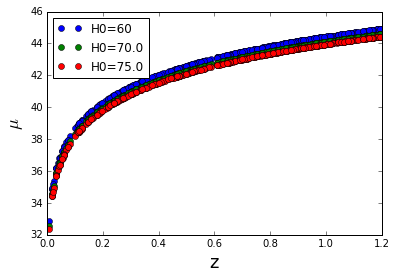

In [9]:
H0s= [60, 70., 75.]
fontsize= 18
for H0 in H0s:
    muTrue= mu(H0= H0, z= zTrue, Om0=0.3)
    plt.plot(zTrue, muTrue, 'o', label= 'H0=%s'%H0)
plt.xlabel('z', fontsize= fontsize)
plt.ylabel('$\mu$', fontsize= fontsize)
plt.legend(loc= "best")